In [1]:
'''
Example implementations of HARK.ConsumptionSaving.ConsPortfolioModel
Mateo's method with parameters embeded inside the notebook
'''
from HARK.ConsumptionSaving.ConsPortfolioModel import PortfolioConsumerType, init_portfolio
from HARK.ConsumptionSaving.ConsIndShockModel import init_lifecycle
from HARK.utilities import plotFuncs
from copy import copy
from time import time
import numpy as np
import matplotlib.pyplot as plt
# If the ipython process contains 'terminal' assume not in a notebook
def in_ipynb():
    try:
        if 'terminal' in str(type(get_ipython())):
            return False
        else:
            return True
    except NameError:
        return False
    
# Determine whether to make the figures inline (for spyder or jupyter)
# vs whatever is the automatic setting that will apply if run from the terminal
if in_ipynb():
    # %matplotlib inline generates a syntax error when run from the shell
    # so do this instead
    get_ipython().run_line_magic('matplotlib', 'inline')
else:
    get_ipython().run_line_magic('matplotlib', 'auto')


In [2]:
import numpy as np
# %% Preferences

# Relative risk aversion
CRRA = 10
# Discount factor
DiscFac = 0.96

# Survival probabilities from the author's Fortran code
n = 80
survprob = np.zeros(n+1)
survprob[1] = 0.99845
survprob[2] = 0.99839
survprob[3] = 0.99833
survprob[4] = 0.9983
survprob[5] = 0.99827
survprob[6] = 0.99826
survprob[7] = 0.99824
survprob[8] = 0.9982
survprob[9] = 0.99813
survprob[10] = 0.99804
survprob[11] = 0.99795
survprob[12] = 0.99785
survprob[13] = 0.99776
survprob[14] = 0.99766
survprob[15] = 0.99755
survprob[16] = 0.99743
survprob[17] = 0.9973
survprob[18] = 0.99718
survprob[19] = 0.99707
survprob[20] = 0.99696
survprob[21] = 0.99685
survprob[22] = 0.99672
survprob[23] = 0.99656
survprob[24] = 0.99635
survprob[25] = 0.9961
survprob[26] = 0.99579
survprob[27] = 0.99543
survprob[28] = 0.99504
survprob[29] = 0.99463
survprob[30] = 0.9942
survprob[31] = 0.9937
survprob[32] = 0.99311
survprob[33] = 0.99245
survprob[34] = 0.99172
survprob[35] = 0.99091
survprob[36] = 0.99005
survprob[37] = 0.98911
survprob[38] = 0.98803
survprob[39] = 0.9868
survprob[40] = 0.98545
survprob[41] = 0.98409
survprob[42] = 0.9827
survprob[43] = 0.98123
survprob[44] = 0.97961
survprob[45] = 0.97786
survprob[46] = 0.97603
survprob[47] = 0.97414
survprob[48] = 0.97207
survprob[49] = 0.9697
survprob[50] = 0.96699
survprob[51] = 0.96393
survprob[52] = 0.96055
survprob[53] = 0.9569
survprob[54] = 0.9531
survprob[55] = 0.94921
survprob[56] = 0.94508
survprob[57] = 0.94057
survprob[58] = 0.9357
survprob[59] = 0.93031
survprob[60] = 0.92424
survprob[61] = 0.91717
survprob[62] = 0.90922
survprob[63] = 0.90089
survprob[64] = 0.89282
survprob[65] = 0.88503
survprob[66] = 0.87622
survprob[67] = 0.86576
survprob[68] = 0.8544
survprob[69] = 0.8423
survprob[70] = 0.82942
survprob[71] = 0.8154
survprob[72] = 0.80002
survprob[73] = 0.78404
survprob[74] = 0.76842
survprob[75] = 0.75382
survprob[76] = 0.73996
survprob[77] = 0.72464
survprob[78] = 0.71057
survprob[79] = 0.6961
survprob[80] = 0.6809

# Fix indexing problem (fortran starts at 1, python at 0)
survprob = np.delete(survprob, [0])
# Now we have 80 probabilities of death,
# for ages 20 to 99.

# Labor income

# They assume its a polinomial of age. Here are the coefficients
a=-2.170042+2.700381
b1=0.16818
b2=-0.0323371/10
b3=0.0019704/100

time_params = {'Age_born': 20, 'Age_retire': 65, 'Age_death': 100}
# 這是一個dictionary對time parameters賦值
t_start = time_params['Age_born']
# 呼叫就用dictionary名稱加上[要的那個參數名字]
t_ret   = time_params['Age_retire'] # We are currently interpreting this as the last period of work
t_end   = time_params['Age_death']

# They assume retirement income is a fraction of labor income in the
# last working period
repl_fac = 0.68212

# Compute average income at each point in (working) life
f = np.arange(t_start, t_ret+1,1)
# array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       # 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       # 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64])
f = a + b1*f + b2*(f**2) + b3*(f**3)
# 對每一個t都算一個多項式值，
det_work_inc = np.exp(f)
# Y_it=exp(f(t,Z_it))


# Retirement income
det_ret_inc = repl_fac*det_work_inc[-1]*np.ones(t_end - t_ret)
# det_work_inc上面那個數列，後面加[-1]是要叫出組後一個數字也就是最後一期的det_work_inc來算retimrement income
# 然後乘上np.ones[]讓他變成數列，退休後到死亡有幾期就有幾個退休收入。
# Get a full vector of the deterministic part of income
det_income = np.concatenate((det_work_inc, det_ret_inc))
# 把退休前收入數列跟退休後收入數列拼接在一起


# ln Gamma_t+1 = f_t+1 - f_t = ln Y_it+1 - ln Y_it
gr_fac = np.exp(np.diff(np.log(det_income)))
# 跟hark内建的gr_fac對應起來

# Now we have growth factors for T_end-1 periods.

# Finally define the normalization factor used by CGM, for plots.
norm_factor = det_income
# 乘以np.exp(0)沒有意義，只是爲了typo place holder.


# %% Shocks

# Transitory and permanent shock variance from the paper
std_tran_shock = np.sqrt(0.0738)
std_perm_shock = np.sqrt(0.0106)
# 文章裏面給了方差，這裏只是進行開根號運算，python裏面沒有，要用np的指令才能開根號，出來是float


# Vectorize. (HARK turns off these shocks after T_retirement)
std_tran_vec = np.array([std_tran_shock]*(t_end-t_start))
std_perm_vec = np.array([std_perm_shock]*(t_end-t_start))
# reminder: t_end=100, t_start = 20
# np.array裏面，[]裏面是你要保留的數目，()裏面是你要有幾項

# %% Financial instruments

# Risk-free factor
Rfree = 1.02

# Creation of risky asset return distributions

Mu = 0.06 # Equity premium
Std = 0.157 # standard deviation of rate-of-return shocks

RiskyAvg = Mu + Rfree
RiskyStd = Std

# Make a dictionary to specify the rest of params
dict_portfolio = { 
                   # Usual params
                   'CRRA': CRRA,
    #前面的紅色是跟consumertype在solve的時候input一模一樣的名稱，冒號後面是數值，這些變量名稱前面都已經定義過數字了例如CRRA=10
                   'Rfree': Rfree,
                   'DiscFac': DiscFac,
                    
                   # Life cycle
                   'T_age' : t_end-t_start+1, # Time of death
                   'T_cycle' : t_end-t_start, # Number of non-terminal periods
                   'T_retire':t_ret-t_start+1,
                   'LivPrb': survprob.tolist(),
                   'PermGroFac': gr_fac.tolist(),
    # 把numpy arrat定義成tolist，HARK要求input 是tolist
                   'cycles': 1,
        
                   # Income shocks
                   'PermShkStd': std_perm_vec,
                   'PermShkCount': 3,
    # Number of points in discrete approximation to permanent income shocks, Carroll ()suggests 7
                   'TranShkStd': std_tran_vec,
                   'TranShkCount': 3,
                   'UnempPrb': 0,
                   'UnempPrbRet': 0,
                   'IncUnemp': 0,
                   'IncUnempRet': 0,
                   'BoroCnstArt': 0,
                   'tax_rate':0.0,
                   
                    # Portfolio related params
                   'RiskyAvg': RiskyAvg,
                   'RiskyStd': RiskyStd,
                   'RiskyCount': 3,
                   'RiskyShareCount': 30,
                  
                   # Grid 
                   'aXtraMin': 0.001,
                   'aXtraMax': 400,
                   'aXtraCount': 400,
                   'aXtraExtra': [None],
                   'aXtraNestFac': 3,
                   
                   # General
                   'vFuncBool': False,
                   'CubicBool': False,
                   
                   # Simulation params
                   'AgentCount': 10,
                   'pLvlInitMean' : np.log(det_income[0]), # Mean of log initial permanent income (only matters for simulation)
                   'pLvlInitStd' : std_perm_shock,  # Standard deviation of log initial permanent income (only matters for simulation)
                   'T_sim': (t_end - t_start+1)*50,
                   
                   # Unused params required for simulation
                   'PermGroFacAgg': 1,
                   'aNrmInitMean': -50.0, # Agents start with 0 assets (this is log-mean)
                   'aNrmInitStd' : 0.0
}

age_plot_params = [20, 30, 55, 75]

In [3]:
# Solve the model with the given parameters
agent = PortfolioConsumerType(**dict_portfolio)
agent.solve()

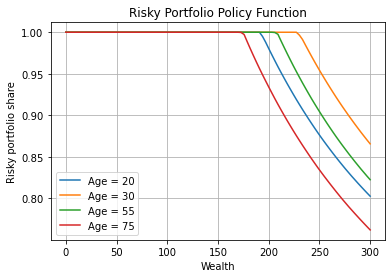

In [4]:
# Create a grid of market resources for the plots
    
mMin = 0    # Minimum ratio of assets to income to plot
mMax = 300 # Maximum ratio of assets to income to plot
mPts = 100 # Number of points to plot 

# Plot portfolio rule
eevalgrid = np.linspace(0,mMax,mPts) # range of values of assets for the plot
# np.linspace()Return evenly spaced numbers over a specified interval.從0到300 分100份,len(eevalgrid)=100
plt.figure()
# In the last period of life you consume everything
# so portfolio choice is irrelevant

# Ages
ages = age_plot_params
#上一個格子最後一行定義
age_born = time_params['Age_born']
for a in ages:
    plt.plot(eevalgrid,
             agent.solution[a-age_born].ShareFuncAdj(eevalgrid/norm_factor[a-age_born]),
             # ShareFuncAdj : Interp1D
        # Risky share function over normalized market resources when the agent is able
        # to adjust their portfolio shares.
             label = 'Age = %i' %(a))
    # 印出來''裏面的string，但''裏面有%i 就是說這裏要replace成一個integer，然後後面用%mark出你要印出來的數字a
plt.xlabel('Wealth')
plt.ylabel('Risky portfolio share')
plt.title('Risky Portfolio Policy Function')
plt.legend()
plt.grid()

if not in_ipynb():
    plt.show(block=False) 
    plt.pause(1)
else:
    plt.show(block=True)
